In [1]:
# import tensorflow as tf

# tf.config.list_physical_devices('GPU')

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import sys
import os
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from scipy.sparse import csr_matrix, load_npz

from recommenders.utils.timer import Timer
from recommenders.datasets.split_utils import filter_k_core

# Transformer Based Models
#from recommenders.models.sasrec.model import SASREC

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

2022-08-26 15:26:53.245315: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import random
from tqdm import tqdm

from recommenders.models.sasrec.model import Encoder
from recommenders.models.sasrec.model import LayerNormalization

In [3]:
random.seed(1)

In [4]:
class SASREC(tf.keras.Model):
    """SAS Rec model
    Self-Attentive Sequential Recommendation Using Transformer
    :Citation:
        Wang-Cheng Kang, Julian McAuley (2018), Self-Attentive Sequential
        Recommendation. Proceedings of IEEE International Conference on
        Data Mining (ICDM'18)
        Original source code from nnkkmto/SASRec-tf2,
        https://github.com/nnkkmto/SASRec-tf2
    """

    def __init__(self, **kwargs):
        """Model initialization.
        Args:
            item_num (int): Number of items in the dataset.
            seq_max_len (int): Maximum number of items in user history.
            num_blocks (int): Number of Transformer blocks to be used.
            embedding_dim (int): Item embedding dimension.
            attention_dim (int): Transformer attention dimension.
            conv_dims (list): List of the dimensions of the Feedforward layer.
            dropout_rate (float): Dropout rate.
            l2_reg (float): Coefficient of the L2 regularization.
            num_neg_test (int): Number of negative examples used in testing.
        """
        super(SASREC, self).__init__()

        self.item_num = kwargs.get("item_num", None)
        self.seq_max_len = kwargs.get("seq_max_len", 100)
        self.num_blocks = kwargs.get("num_blocks", 2)
        self.embedding_dim = kwargs.get("embedding_dim", 100)
        self.attention_dim = kwargs.get("attention_dim", 100)
        self.attention_num_heads = kwargs.get("attention_num_heads", 1)
        self.conv_dims = kwargs.get("conv_dims", [100, 100])
        self.dropout_rate = kwargs.get("dropout_rate", 0.5)
        self.l2_reg = kwargs.get("l2_reg", 0.0)
        self.num_neg_test = kwargs.get("num_neg_test", 100)
        self.num_val_users = kwargs.get("num_val_users", 100)

        self.item_embedding_layer = tf.keras.layers.Embedding(
            self.item_num + 1,
            self.embedding_dim,
            name="item_embeddings",
            mask_zero=True,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )

        self.positional_embedding_layer = tf.keras.layers.Embedding(
            self.seq_max_len,
            self.embedding_dim,
            name="positional_embeddings",
            mask_zero=False,
            embeddings_regularizer=tf.keras.regularizers.L2(self.l2_reg),
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)
        self.encoder = Encoder(
            self.num_blocks,
            self.seq_max_len,
            self.embedding_dim,
            self.attention_dim,
            self.attention_num_heads,
            self.conv_dims,
            self.dropout_rate,
        )
        self.mask_layer = tf.keras.layers.Masking(mask_value=0)
        self.layer_normalization = LayerNormalization(
            self.seq_max_len, self.embedding_dim, 1e-08
        )

    def embedding(self, input_seq):
        """Compute the sequence and positional embeddings.
        Args:
            input_seq (tf.Tensor): Input sequence
        Returns:
            tf.Tensor, tf.Tensor:
            - Sequence embeddings.
            - Positional embeddings.
        """

        seq_embeddings = self.item_embedding_layer(input_seq)
        seq_embeddings = seq_embeddings * (self.embedding_dim ** 0.5)

        # FIXME
        positional_seq = tf.expand_dims(tf.range(tf.shape(input_seq)[1]), 0)
        positional_seq = tf.tile(positional_seq, [tf.shape(input_seq)[0], 1])
        positional_embeddings = self.positional_embedding_layer(positional_seq)

        return seq_embeddings, positional_embeddings

    def call(self, x, training):
        """Model forward pass.
        Args:
            x (tf.Tensor): Input tensor.
            training (tf.Tensor): Training tensor.
        Returns:
            tf.Tensor, tf.Tensor, tf.Tensor:
            - Logits of the positive examples.
            - Logits of the negative examples.
            - Mask for nonzero targets
        """

        input_seq = x["input_seq"]
        pos = x["positive"]
        neg = x["negative"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)

        # add positional embeddings
        seq_embeddings += positional_embeddings

        # dropout
        seq_embeddings = self.dropout_layer(seq_embeddings)

        # masking
        seq_embeddings *= mask

        # --- ATTENTION BLOCKS ---
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)

        # --- PREDICTION LAYER ---
        # user's sequence embedding
        pos = self.mask_layer(pos)
        neg = self.mask_layer(neg)

        pos = tf.reshape(pos, [tf.shape(input_seq)[0] * self.seq_max_len])
        neg = tf.reshape(neg, [tf.shape(input_seq)[0] * self.seq_max_len])
        pos_emb = self.item_embedding_layer(pos)
        neg_emb = self.item_embedding_layer(neg)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)

        pos_logits = tf.reduce_sum(pos_emb * seq_emb, -1)
        neg_logits = tf.reduce_sum(neg_emb * seq_emb, -1)

        pos_logits = tf.expand_dims(pos_logits, axis=-1)  # (bs, 1)
        # pos_prob = tf.keras.layers.Dense(1, activation='sigmoid')(pos_logits)  # (bs, 1)

        neg_logits = tf.expand_dims(neg_logits, axis=-1)  # (bs, 1)
        # neg_prob = tf.keras.layers.Dense(1, activation='sigmoid')(neg_logits)  # (bs, 1)

        # output = tf.concat([pos_logits, neg_logits], axis=0)

        # masking for loss calculation
        istarget = tf.reshape(
            tf.cast(tf.not_equal(pos, 0), dtype=tf.float32),
            [tf.shape(input_seq)[0] * self.seq_max_len],
        )

        return pos_logits, neg_logits, istarget

    def predict(self, inputs):
        """Returns the logits for the test items.
        Args:
            inputs (tf.Tensor): Input tensor.
        Returns:
             tf.Tensor: Output tensor.
        """
        training = False
        input_seq = inputs["input_seq"]
        candidate = inputs["candidate"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)
        seq_embeddings += positional_embeddings
        # seq_embeddings = self.dropout_layer(seq_embeddings)
        seq_embeddings *= mask
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)
        candidate_emb = self.item_embedding_layer(candidate)  # (b, s, d)
        candidate_emb = tf.transpose(candidate_emb, perm=[0, 2, 1])  # (b, d, s)

        test_logits = tf.matmul(seq_emb, candidate_emb)
        # (200, 100) * (1, 101, 100)'

        test_logits = tf.reshape(
            test_logits,
            [tf.shape(input_seq)[0], self.seq_max_len, 1 + self.num_neg_test],
        )  # (1, 200, 101)
        test_logits = test_logits[:, -1, :]  # (1, 101)
        return test_logits

    def loss_function(self, pos_logits, neg_logits, istarget):
        """Losses are calculated separately for the positive and negative
        items based on the corresponding logits. A mask is included to
        take care of the zero items (added for padding).
        Args:
            pos_logits (tf.Tensor): Logits of the positive examples.
            neg_logits (tf.Tensor): Logits of the negative examples.
            istarget (tf.Tensor): Mask for nonzero targets.
        Returns:
            float: Loss.
        """

        pos_logits = pos_logits[:, 0]
        neg_logits = neg_logits[:, 0]

        # ignore padding items (0)
        # istarget = tf.reshape(
        #     tf.cast(tf.not_equal(self.pos, 0), dtype=tf.float32),
        #     [tf.shape(self.input_seq)[0] * self.seq_max_len],
        # )
        # for logits
        loss = tf.reduce_sum(
            -tf.math.log(tf.math.sigmoid(pos_logits) + 1e-24) * istarget
            - tf.math.log(1 - tf.math.sigmoid(neg_logits) + 1e-24) * istarget
        ) / tf.reduce_sum(istarget)

        # for probabilities
        # loss = tf.reduce_sum(
        #         - tf.math.log(pos_logits + 1e-24) * istarget -
        #         tf.math.log(1 - neg_logits + 1e-24) * istarget
        # ) / tf.reduce_sum(istarget)
        reg_loss = tf.compat.v1.losses.get_regularization_loss()
        # reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
        # loss += sum(reg_losses)
        loss += reg_loss

        return loss

    def create_combined_dataset(self, u, seq, pos, neg):
        """
        function to create model inputs from sampled batch data.
        This function is used only during training.
        """
        inputs = {}
        seq = tf.keras.preprocessing.sequence.pad_sequences(
            seq, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        pos = tf.keras.preprocessing.sequence.pad_sequences(
            pos, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )
        neg = tf.keras.preprocessing.sequence.pad_sequences(
            neg, padding="pre", truncating="pre", maxlen=self.seq_max_len
        )

        inputs["users"] = np.expand_dims(np.array(u), axis=-1)
        inputs["input_seq"] = seq
        inputs["positive"] = pos
        inputs["negative"] = neg

        target = np.concatenate(
            [
                np.repeat(1, seq.shape[0] * seq.shape[1]),
                np.repeat(0, seq.shape[0] * seq.shape[1]),
            ],
            axis=0,
        )
        target = np.expand_dims(target, axis=-1)
        return inputs, target

    def train(self, dataset, sampler, **kwargs):
        """
        High level function for model training as well as
        evaluation on the validation and test dataset
        """
        num_epochs = kwargs.get("num_epochs", 10)
        batch_size = kwargs.get("batch_size", 128)
        lr = kwargs.get("learning_rate", 0.001)
        val_epoch = kwargs.get("val_epoch", 5)

        num_steps = int(len(dataset.user_train) / batch_size)

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-7
        )

        loss_function = self.loss_function

        train_loss = tf.keras.metrics.Mean(name="train_loss")

        train_step_signature = [
            {
                "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
                "input_seq": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "positive": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
                "negative": tf.TensorSpec(
                    shape=(None, self.seq_max_len), dtype=tf.int64
                ),
            },
            tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        ]

        @tf.function(input_signature=train_step_signature)
        def train_step(inp, tar):
            with tf.GradientTape() as tape:
                pos_logits, neg_logits, loss_mask = self(inp, training=True)
                loss = loss_function(pos_logits, neg_logits, loss_mask)

            gradients = tape.gradient(loss, self.trainable_variables)
            #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            train_loss(loss)
            return loss

        T = 0.0
        t0 = Timer()
        t0.start()

        for epoch in range(1, num_epochs + 1):

            WATCH_LOSS = 0
            counter = 0
            step_loss = []
            train_loss.reset_states()
            for step in tqdm(
                range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
            ):

                u, seq, pos, neg = sampler.next_batch()

                inputs, target = self.create_combined_dataset(u, seq, pos, neg)

                loss = train_step(inputs, target)
                step_loss.append(loss)
                WATCH_LOSS += loss
                counter += 1
            
            print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
            if epoch % val_epoch == 0:
                t0.stop()
                t1 = t0.interval
                T += t1
                print("Evaluating...")
                t_test = self.evaluate(dataset)
                t_valid = self.evaluate_valid(dataset)
                print(
                    f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
                )
                print(
                    f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
                )
                t0.start()

        
        t_test = self.evaluate(dataset)
        print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")

        return t_test

    def evaluate(self, dataset):
        """
        Evaluation on the test users (users with at least 3 items)
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid
        test = dataset.user_test

        NDCG = 0.0
        HT = 0.0
        valid_user = 0.0

        if usernum > self.num_val_users:
            users = random.sample(range(1, usernum + 1), self.num_val_users)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):

            if len(train[u]) < 1 or len(test[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            seq[idx] = valid[u][0]
            idx -= 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break
            rated = set(train[u])
            rated.add(0)
            item_idx = [test[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # inverse to get descending sort
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user

    def evaluate_valid(self, dataset):
        """
        Evaluation on the validation users
        """
        usernum = dataset.usernum
        itemnum = dataset.itemnum
        train = dataset.user_train  # removing deepcopy
        valid = dataset.user_valid

        NDCG = 0.0
        valid_user = 0.0
        HT = 0.0
        if usernum > self.num_val_users:
            users = random.sample(range(1, usernum + 1), self.num_val_users)
        else:
            users = range(1, usernum + 1)

        for u in tqdm(users, ncols=70, leave=False, unit="b"):
            if len(train[u]) < 1 or len(valid[u]) < 1:
                continue

            seq = np.zeros([self.seq_max_len], dtype=np.int32)
            idx = self.seq_max_len - 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1:
                    break

            rated = set(train[u])
            rated.add(0)
            item_idx = [valid[u][0]]
            for _ in range(self.num_neg_test):
                t = np.random.randint(1, itemnum + 1)
                while t in rated:
                    t = np.random.randint(1, itemnum + 1)
                item_idx.append(t)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # predictions = -model.predict(sess, [u], [seq], item_idx)
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            rank = predictions.argsort().argsort()[0]

            valid_user += 1

            if rank < 10:
                NDCG += 1 / np.log2(rank + 2)
                HT += 1

        return NDCG / valid_user, HT / valid_user
    
    def get_user_embedding(self, inputs):
        """Returns the logits for the test items.

        Args:
            inputs (tf.Tensor): Input tensor.

        Returns:
             np.ndarray
        """
        training = False
        input_seq = inputs["input_seq"]

        mask = tf.expand_dims(tf.cast(tf.not_equal(input_seq, 0), tf.float32), -1)
        seq_embeddings, positional_embeddings = self.embedding(input_seq)
        seq_embeddings += positional_embeddings
        # seq_embeddings = self.dropout_layer(seq_embeddings)
        seq_embeddings *= mask
        seq_attention = seq_embeddings
        seq_attention = self.encoder(seq_attention, training, mask)
        seq_attention = self.layer_normalization(seq_attention)  # (b, s, d)
        seq_emb = tf.reshape(
            seq_attention,
            [tf.shape(input_seq)[0] * self.seq_max_len, self.embedding_dim],
        )  # (b*s, d)

        return seq_emb.numpy()[np.where(mask.numpy().reshape(-1, 1) == 1)[0]].mean(axis=0)

In [5]:
# data_init = pd.read_csv('final_data_7_days.gzip', compression='gzip')

In [6]:
# и в исходной статье они как будто сохраняли сначала “userID” потом “itemID”
# data_init.head()

In [7]:
# data_init['uid_idx'].nunique(), data_init['offer_idx'].nunique()

In [8]:
# data_init[['uid_idx', 'offer_idx']].to_csv('final_data_7_days.txt', sep="\t", header=False, index=False)

In [9]:
# create special data format for SAS
dataS = SASRecDataSet(filename='final_data_7_days.txt', col_sep='\t')
# split into train, test and validation
dataS.split()

In [10]:
dataS.usernum, dataS.itemnum

(442993, 400000)

In [11]:
# model variables
num_epochs = 80
batch_size = 600   #                                                         !!!
RANDOM_SEED = 100  # Set None for non-deterministic result
lr = 0.001             # learning rate                                       !!!
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation.       !!!
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient                       !!!
num_neg_test = dataS.itemnum  # number of negative examples per positive example

In [12]:
# sample negative examples
sampler = WarpSampler(dataS.user_train, dataS.usernum, 
                      dataS.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

Process Process-1:
Process Process-2:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/home/emikhailova/miniconda3/envs/tf/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._ar

In [13]:
model = SASREC(item_num=dataS.itemnum,
               seq_max_len=maxlen,
               num_blocks=num_blocks,
               embedding_dim=hidden_units,
               attention_dim=hidden_units,
               attention_num_heads=num_heads,
               dropout_rate=dropout_rate,
               conv_dims = [hidden_units, hidden_units],         ### !!!
               l2_reg=l2_emb,
               num_neg_test=num_neg_test,
               num_val_users=300)

2022-08-26 15:27:15.888485: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-26 15:27:15.916172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-08-26 15:27:15.917402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-08-26 15:27:15.917977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 981.38MiB deviceMemoryBandwidth: 18.

In [14]:
model.load_weights('models_my_data/model_epoch_55_loss_0.0357')

In [16]:
u, seq, pos, neg = sampler.next_batch()

inputs, target = model.create_combined_dataset(u, seq, pos, neg)

In [17]:
a = model(inputs, training=True)

2022-08-24 15:45:40.970555: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [19]:
a[0].shape, a[1].shape, a[2].shape

(TensorShape([30000, 1]), TensorShape([30000, 1]), TensorShape([30000]))

In [15]:
dataset = dataS
val_epoch = 5

num_steps = int(len(dataset.user_train) / batch_size)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr / 8, beta_1=0.9, beta_2=0.999, epsilon=1e-7
)

loss_function = model.loss_function

train_loss = tf.keras.metrics.Mean(name="train_loss")

train_step_signature = [
    {
        "users": tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
        "input_seq": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "positive": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
        "negative": tf.TensorSpec(
            shape=(None, model.seq_max_len), dtype=tf.int64
        ),
    },
    tf.TensorSpec(shape=(None, 1), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        pos_logits, neg_logits, loss_mask = model(inp, training=True)
        loss = loss_function(pos_logits, neg_logits, loss_mask)

    gradients = tape.gradient(loss, model.trainable_variables)
    #gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return loss

T = 0.0
t0 = Timer()
t0.start()

for epoch in range(56, num_epochs + 1):

    WATCH_LOSS = 0
    counter = 0
    step_loss = []
    train_loss.reset_states()
#     self.set_learning_rate(epoch)
    
    for step in tqdm(
        range(num_steps), total=num_steps, ncols=70, leave=False, unit="b"
    ):

        u, seq, pos, neg = sampler.next_batch()

        inputs, target = model.create_combined_dataset(u, seq, pos, neg)

        loss = train_step(inputs, target)
        step_loss.append(loss)
#         if step % 10 == 0:
#             model.save_weights(f'models/model_epoch_last_loss_none_v2_{epoch}_step_{step}')
        if np.isnan(loss.numpy()):
            model.save_weights(f'models_my_data/model_epoch_last_loss_none_{epoch}')
            print('loss nan')
            break
#         if step % 100 == 0:
#             print(loss.numpy())
        WATCH_LOSS += loss.numpy()
        counter += 1
        
#     if epoch % 10 == 0:
#         optimizer.lr = optimizer.lr / 5
#         print('lr reduced', optimizer.lr)
    
    print(f"\nIn {epoch} epoch the LOSS is {WATCH_LOSS/counter}")
    if epoch % val_epoch == 0:
        t0.stop()
        t1 = t0.interval
        T += t1
        print("Evaluating...")
        t_test = model.evaluate(dataset)
        t_valid = model.evaluate_valid(dataset)
        print(
            f"\nepoch: {epoch}, time: {T}, valid (NDCG@10: {t_valid[0]}, HR@10: {t_valid[1]})"
        )
        print(
            f"epoch: {epoch}, time: {T},  test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})"
        )
        t0.start()

    model.save_weights(f'models_my_data/model_epoch_{epoch}_loss_{round(WATCH_LOSS/counter, 4)}')
t_test = model.evaluate(dataset)
print(f"\nepoch: {epoch}, test (NDCG@10: {t_test[0]}, HR@10: {t_test[1]})")

  0%|                                          | 0/738 [00:00<?, ?b/s]2022-08-23 19:02:55.678699: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-23 19:02:56.209733: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-08-23 19:02:56.904339: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-08-23 19:02:56.973036: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



In 56 epoch the LOSS is 0.03579507234852085



In 57 epoch the LOSS is 0.0363879500052874


KeyboardInterrupt: 

In [16]:
embeds_all = []

for start in tqdm(range(0, 100000, 10)):
    test_arr = np.arange(start, start + 10).reshape(-1, 1)
    embeds = model.embedding(test_arr)[0].numpy().reshape(-1, 100).tolist()
    embeds_all.extend(embeds)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 669.59it/s]


In [38]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(verbose=10)
a = tsne.fit_transform(embeds_all)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.008s...
[t-SNE] Computed neighbors for 100000 samples in 304.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [41]:
import matplotlib.pyplot as plt

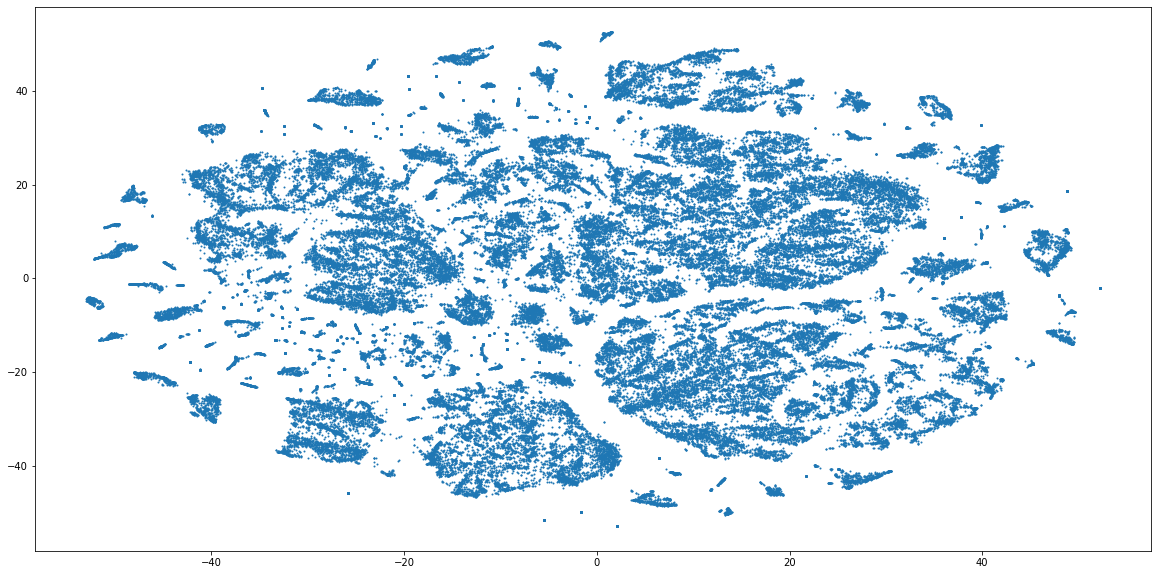

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(x=a[:,0], y=a[:,1], s=1)

In [20]:
test_data = pd.read_csv('test_data_7_days_to_final_data_7_days.gzip', compression='gzip')

In [21]:
data_init = pd.read_csv('final_data_7_days.gzip', compression='gzip')

In [22]:
offer_map = data_init[['offer_id', 'offer_idx']].set_index('offer_id')['offer_idx'].to_dict()

In [25]:
offer_map[268093759]

144199

In [33]:
test_data.head(2)

,uid,ids_seq,ids_in_train,ids_in_train1,len_ids,len_ids1,mean_ids,mean_ids1,ids_seq_filtered,ids_seq_index,ids_seq_cat,sale,rent,target
0,0006f270-81e7-48cd-81bd-2ae98fab68b9,"[275225150, 269462306, 272188084, 268093759, 2...","[True, True, True, True, True, True]","[True, True, True, True, True, True]",6,6,1.0,1.0,"[275225150, 269462306, 272188084, 268093759, 2...","[19798, 223060, 38650, 144199, 39842, 146137]","['sale', 'sale', 'sale', 'sale', 'sale', 'sale']",1.0,NaN,0
1,000A58C3-5C55-460F-82AD-FFD7B643020F,"[269716645, 252061191, 273474302, 274505091, 2...","[True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, True]",8,8,1.0,1.0,"[269716645, 252061191, 273474302, 274505091, 2...","[135976, 158885, 159179, 93670, 68020, 99078, ...","['sale', 'sale', 'sale', 'sale', 'sale', 'sale...",1.0,NaN,0


In [26]:
import json
test_data['ids_seq_filtered'] = test_data['ids_seq_filtered'].apply(lambda x: [int(i) for i in x[1:-1].split()])

In [29]:
test_data['ids_seq_index'] = test_data['ids_seq_index'].apply(lambda x: [int(i) for i in x[1:-1].split(', ')])

In [35]:
test_data.shape

(43798, 14)

In [32]:
test_data['ids_seq_index'].iloc[10]

[381223, 12180, 368904, 46830, 345625, 387986, 57492, 333762, 4128, 395353]

In [30]:
test_data.head()

,uid,ids_seq,ids_in_train,ids_in_train1,len_ids,len_ids1,mean_ids,mean_ids1,ids_seq_filtered,ids_seq_index,ids_seq_cat,sale,rent,target
0,0006f270-81e7-48cd-81bd-2ae98fab68b9,"[275225150, 269462306, 272188084, 268093759, 2...","[True, True, True, True, True, True]","[True, True, True, True, True, True]",6,6,1.000000,1.000000,"[275225150, 269462306, 272188084, 268093759, 2...","[19798, 223060, 38650, 144199, 39842, 146137]","['sale', 'sale', 'sale', 'sale', 'sale', 'sale']",1.0,NaN,0
1,000A58C3-5C55-460F-82AD-FFD7B643020F,"[269716645, 252061191, 273474302, 274505091, 2...","[True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, True]",8,8,1.000000,1.000000,"[269716645, 252061191, 273474302, 274505091, 2...","[135976, 158885, 159179, 93670, 68020, 99078, ...","['sale', 'sale', 'sale', 'sale', 'sale', 'sale...",1.0,NaN,0
2,000A76B0-4508-44B2-8CC7-CFABECAB8F05,"[275890325, 274987503, 273857164, 272292552, 2...","[False, True, True, True, True, True, True, Tr...","[False, True, True, True, True, True, True, Tr...",15,15,0.933333,0.933333,"[274987503, 273857164, 272292552, 268346699, 2...","[84405, 2125, 325625, 107616, 59229, 49001, 30...","['sale', 'sale', 'sale', 'sale', 'sale', 'sale...",1.0,NaN,0
3,000F46C8-0F2F-4595-B0BC-2E5C0EAD5668,"[266426948, 258802618, 269549363, 274819056, 2...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",9,9,1.000000,1.000000,"[266426948, 258802618, 269549363, 274819056, 2...","[323641, 43500, 373411, 140970, 174435, 172360...","['sale', 'sale', 'sale', 'sale', 'sale', 'sale...",1.0,NaN,0
4,000ce71d-e87f-4e76-901f-decef1606cea,"[275478971, 275471459, 275369810, 273311076, 2...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",26,26,1.000000,1.000000,"[275478971, 275471459, 275369810, 273311076, 2...","[234810, 155594, 92331, 92321, 363765, 36328, ...","['sale', 'sale', 'sale', 'sale', 'sale', 'sale...",1.0,NaN,0


In [36]:
embeds_users_all = []
for ind, seq in tqdm(enumerate(test_data['ids_seq_index'].values, start=1)):
    inputs = {}
    inputs["user"] = np.expand_dims(np.array([ind]), axis=-1)
    if len(seq) < 50:
        seq = [0 for i in range(50 - len(seq))] + seq
        
    else:
        seq = seq[-50:]
        
    inputs["input_seq"] = np.array([seq])
    user_emb = model.get_user_embedding(inputs)
    embeds_users_all.append(user_emb)

43798it [09:55, 73.53it/s]


In [39]:
tsne_users = TSNE(verbose=10)
users_tsne_vals = tsne_users.fit_transform(embeds_users_all)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 43798 samples in 0.003s...
[t-SNE] Computed neighbors for 43798 samples in 40.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43798
[t-SNE] Computed conditional probabilities for sample 2000 / 43798
[t-SNE] Computed conditional probabilities for sample 3000 / 43798
[t-SNE] Computed conditional probabilities for sample 4000 / 43798
[t-SNE] Computed conditional probabilities for sample 5000 / 43798
[t-SNE] Computed conditional probabilities for sample 6000 / 43798
[t-SNE] Computed conditional probabilities for sample 7000 / 43798
[t-SNE] Computed conditional probabilities for sample 8000 / 43798
[t-SNE] Computed conditional probabilities for sample 9000 / 43798
[t-SNE] Computed conditional probabilities for sample 10000 / 43798
[t-SNE] Computed conditional probabilities for sample 11000 / 43798
[t-SNE] Computed conditional probabilities for sample 12000 / 43798
[t-SNE] Computed conditional probabilities for sa

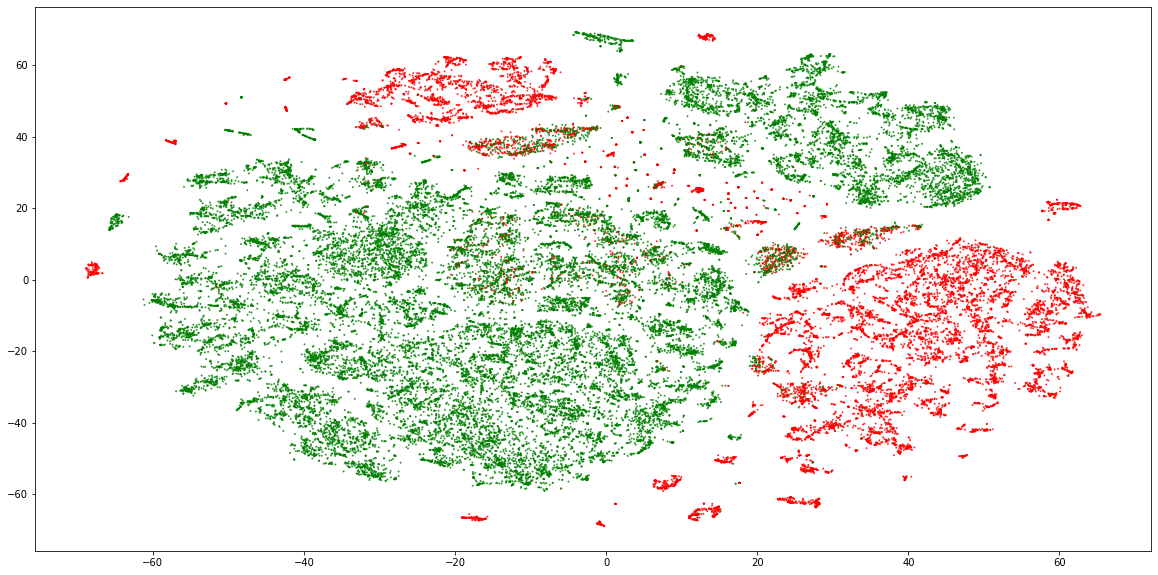

In [49]:
plt.figure(figsize=(20, 10))
plt.scatter(x=users_tsne_vals[:,0], y=users_tsne_vals[:,1], s=1, c=test_data['target'].map({1:'r', 0:'g'}), 
            alpha=0.7)

In [43]:
test_data['user_embed'] = embeds_users_all

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(embeds_users_all, test_data['target'], 
                                                    test_size=0.2, random_state=42)

In [69]:
test_data_test_part = test_data.loc[y_test.index]

In [62]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000, 
    depth=3, 
    early_stopping_rounds=20,
    learning_rate=0.4
)

model.fit(X_train,
          y_train,
          verbose=True, eval_set=(X_test, y_test))

0:	learn: 0.5579967	test: 0.5596767	best: 0.5596767 (0)	total: 6.27ms	remaining: 6.26s
1:	learn: 0.4884910	test: 0.4892237	best: 0.4892237 (1)	total: 12ms	remaining: 6.01s
2:	learn: 0.4453762	test: 0.4470374	best: 0.4470374 (2)	total: 17.2ms	remaining: 5.73s
3:	learn: 0.4026231	test: 0.4062083	best: 0.4062083 (3)	total: 22.5ms	remaining: 5.61s
4:	learn: 0.3722223	test: 0.3758288	best: 0.3758288 (4)	total: 27.6ms	remaining: 5.49s
5:	learn: 0.3519045	test: 0.3554970	best: 0.3554970 (5)	total: 32.3ms	remaining: 5.35s
6:	learn: 0.3320756	test: 0.3353053	best: 0.3353053 (6)	total: 37.1ms	remaining: 5.26s
7:	learn: 0.3148714	test: 0.3196671	best: 0.3196671 (7)	total: 41.8ms	remaining: 5.18s
8:	learn: 0.3020277	test: 0.3064394	best: 0.3064394 (8)	total: 46.3ms	remaining: 5.1s
9:	learn: 0.2883358	test: 0.2924097	best: 0.2924097 (9)	total: 51ms	remaining: 5.05s
10:	learn: 0.2779091	test: 0.2808357	best: 0.2808357 (10)	total: 55.6ms	remaining: 5s
11:	learn: 0.2679122	test: 0.2713329	best: 0.2713

In [64]:
pred = model.predict_proba(X_test)

In [70]:
test_data_test_part['pred'] = pred[:, 1]

In [82]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix

In [75]:
roc_auc_score(test_data_test_part['target'], test_data_test_part['pred'])

0.9975251690937966

In [76]:
test_data_test_part['target'].value_counts(normalize=True)

0    0.685616
1    0.314384
Name: target, dtype: float64

In [80]:
recall_score(test_data_test_part['target'], (test_data_test_part['pred'] > 0.5))

0.9600580973129993

In [81]:
precision_score(test_data_test_part['target'], (test_data_test_part['pred'] > 0.5))

0.9713445995591476

In [83]:
confusion_matrix(test_data_test_part['target'], (test_data_test_part['pred'] > 0.5))

array([[5928,   78],
       [ 110, 2644]])